In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import midynet
import pathlib
from pyhectiqlab import Run

from itertools import product
from matplotlib.lines import Line2D
from midynet.statistics import Statistics
from midynet.utility import display

paths_to_figures = [pathlib.Path("./")]

run = Run("Mutual information versus heuristics figure", project="dynamica/midynet")

run.add_dataset_usage(
    "midynet1-duality-data", 
    version="1.0.1", 
)
run.add_artifact("mi-vs-heuristics.ipynb")

Attaching to an existing run (ID :30).


In [8]:
path_to_data = pathlib.Path("../../scripts/duality/data/mi-vs-heuristics/")

df = next(iter(pd.read_pickle("../../scripts/duality/data/numerical-validation/glauber-large-meanfield/reconinfo.pkl").values()))
mf = Statistics.from_dataframe(df, "mutualinfo")
mf.rescale_(1/8)
mf_x = df["data_model.coupling"]

df = next(iter(pd.read_pickle("../../scripts/duality/data/numerical-validation/glauber-large-annealed/reconinfo.pkl").values()))
ais = Statistics.from_dataframe(df, "mutualinfo")
# ais.rescale_(1/8)
ais_x = df["data_model.coupling"]

prior = df["prior-loc"][0]

pred_df = next(iter(pd.read_pickle(path_to_data / "pred_error.pkl").values()))
pred_x = pred_df["data_model.coupling"]
pred_methods = pred_df["metrics.predictor"].values
all_pred_methods = np.unique(pred_methods)
pred = Statistics.from_dataframe(pred_df, "absolute_error")

recon_df = next(iter(pd.read_pickle(path_to_data / "reconheuristics.pkl").values()))
recon_x = recon_df["data_model.coupling"]
recon_methods = recon_df["metrics.method"].values
all_recon_methods = np.unique(recon_methods)
recon = Statistics.from_dataframe(recon_df, "auc")

recon_method_labels = {
    "correlation": "Correlation",
    "granger_causality": "Granger",
    "transfer_entropy": "Transfer entropy",
}
pred_method_labels = {
    "average_probability": "Average prob.",
    "mle": "MLE",
    "logistic": "Logistic",
    "mlp": "MLP",
}


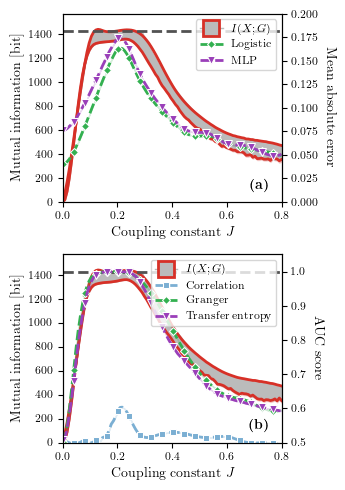

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(3.5, 5))
display.Label.clear()

mi_color = display.med_colors["red"]
fcolor = "#bbbbbb"

hcolor = [display.light_colors["blue"], display.med_colors["green"], display.dark_colors["purple"]]
hmarker = ["s", "D", "v"]
hlinestyle = ["--"] * 3

# Prediction figure
mf.clip(min=0, max=prior).lineplot(
    mf_x, 
    color=mi_color, 
    marker="None", 
    linestyle="-", 
    linewidth=2, 
    markersize=6, 
    interpolate="cubic",
    markevery=5,
    n_boot=1000,
    ax=ax[0],
)

ais.clip(min=0, max=prior).lineplot(
    ais_x, 
    color=mi_color, 
    marker="None", 
    linestyle="-", 
    linewidth=2, 
    markersize=6, 
    interpolate="cubic",
    markevery=5,
    n_boot=1000,
    ax=ax[0],
)

augx, mf_augy = mf.interpolate(mf_x, kind="cubic")
_, ais_augy = ais.interpolate(ais_x, kind="cubic")
mf_augy = mf_augy.clip(0, prior)
ais_augy = ais_augy.clip(0, prior)
ax[0].fill_between(augx, mf_augy.loc, ais_augy.loc, color=fcolor)
handles = [
    display.get_label_line(
        r"$I(X;G)$", 
        marker="s",
        markersize=12,
        color=fcolor,
        markeredgecolor=mi_color,
        alpha=1,
        markeredgewidth=2,
    )
]

ax[0].axhline(prior, color=display.med_colors["grey"], linewidth=2, linestyle="--")
ax[0].set_xlabel(r"Coupling constant $J$", fontsize=display.fontsizes["label"])
ax[0].set_ylabel(r"Mutual information [bit]", fontsize=display.fontsizes["label"])
ax[0].set_xlim([mf_x.min(), mf_x.max()])
ax[0].set_ylim([0, prior * 1.1])
ax[0].tick_params(axis="both", labelsize=display.fontsizes["tick"])

axx = ax[0].twinx()
# ax.set_zorder(axx.get_zorder() + 1)
# ax.patch.set_visible(False)
for i, m in enumerate(all_pred_methods):
    if m == "average_probability":
        continue
    idx = pred_methods == m
    x = pred_x[idx]
    pred[idx].lineplot(
        x, 
        color=hcolor[i],
        linestyle=hlinestyle[i],
        marker=hmarker[i],
        linewidth=2,
        markersize=6 if i == 2 else 4,
        interpolate="cubic",
        markevery=5,
        n_boot=1000,
    )
    handles.append(display.get_label_line(pred_method_labels[m], style=axx.get_lines()[-1]))
axx.set_ylim([0.0, 0.2])
axx.set_ylabel(r"Mean absolute error", rotation=-90, ha="center", va="bottom", fontsize=display.fontsizes["label"])
axx.tick_params(axis="both", labelsize=display.fontsizes["tick"])
ax[0].legend(handles=handles, fontsize=display.fontsizes["legend"], loc="upper right")
display.Label.plot(ax[0], loc="bottom right")

# Reconstruction figure
mf.clip(min=0, max=prior).lineplot(
    mf_x, 
    color=mi_color, 
    marker="None", 
    linestyle="-", 
    linewidth=2, 
    markersize=6, 
    interpolate="cubic",
    markevery=5,
    n_boot=1000,
    ax=ax[1],
)

ais.clip(min=0, max=prior).lineplot(
    ais_x, 
    color=mi_color, 
    marker="None", 
    linestyle="-", 
    linewidth=2, 
    markersize=6, 
    interpolate="cubic",
    markevery=5,
    n_boot=1000,
    ax=ax[1],
)

augx, mf_augy = mf.interpolate(mf_x, kind="cubic")
_, ais_augy = ais.interpolate(ais_x, kind="cubic")
mf_augy = mf_augy.clip(0, prior)
ais_augy = ais_augy.clip(0, prior)
ax[1].fill_between(augx, mf_augy.loc, ais_augy.loc, color=fcolor)
handles = [
    display.get_label_line(
        r"$I(X;G)$", 
        marker="s",
        markersize=12,
        color=fcolor,
        markeredgecolor=mi_color,
        alpha=1,
        markeredgewidth=2,
    )
]

ax[1].axhline(prior, color=display.med_colors["grey"], linewidth=2, linestyle="--")
ax[1].set_xlabel(r"Coupling constant $J$", fontsize=display.fontsizes["label"])
ax[1].set_ylabel(r"Mutual information [bit]", fontsize=display.fontsizes["label"])
ax[1].set_xlim([mf_x.min(), mf_x.max()])
ax[1].set_ylim([0, prior * 1.1])
ax[1].tick_params(axis="both", labelsize=display.fontsizes["tick"])

axx = ax[1].twinx()
# ax.set_zorder(axx.get_zorder() + 1)
# ax.patch.set_visible(False)
for i, m in enumerate(all_recon_methods):
    idx = recon_methods == m
    x = recon_x[idx]
    recon[idx].lineplot(
        x, 
        color=hcolor[i],
        linestyle=hlinestyle[i],
        marker=hmarker[i],
        linewidth=2,
        markersize=6 if i == 2 else 4,
        interpolate="cubic",
        markevery=5,
        n_boot=1000,
    )
    handles.append(display.get_label_line(recon_method_labels[m], style=axx.get_lines()[-1]))
axx.set_ylim([0.5, 1.05])
axx.set_ylabel(r"AUC score", rotation=-90, ha="center", va="bottom", fontsize=display.fontsizes["label"])
axx.tick_params(axis="both", labelsize=display.fontsizes["tick"])
axx.legend(handles=handles, fontsize=display.fontsizes["legend"], loc="upper right")
display.Label.plot(ax[1], loc="bottom right")

fig.tight_layout()

for p, fmt in product(paths_to_figures, ["svg", "pdf", "png"]):
    fig.savefig(p / f"{fmt}/mi-vs-heuristics.{fmt}", bbox_inches='tight')
    
run.add_figure(fig, "mi-vs-heuristics")

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import midynet
import pathlib
from pyhectiqlab import Run

from itertools import product
from matplotlib.lines import Line2D
from midynet.statistics import Statistics
from midynet.utility import display

paths_to_figures = [pathlib.Path("./")]

In [20]:
path_to_data = pathlib.Path("../../scripts/duality/data/mi-vs-heuristics/")

df = next(iter(pd.read_pickle("../../scripts/duality/data/numerical-validation/glauber-large-meanfield/reconinfo.pkl").values()))
mf = Statistics.from_dataframe(df, "recon")
mf.rescale_(1/8)
mf_x = df["data_model.coupling"]

df = next(iter(pd.read_pickle("../../scripts/duality/data/numerical-validation/glauber-large-annealed/reconinfo.pkl").values()))
ais = Statistics.from_dataframe(df, "recon")
# ais.rescale_(1/8)
ais_x = df["data_model.coupling"]

prior = df["prior-loc"][0]

recon_df = next(iter(pd.read_pickle(path_to_data / "reconheuristics.pkl").values()))
recon_x = recon_df["data_model.coupling"]
recon_methods = recon_df["metrics.method"].values
all_recon_methods = np.unique(recon_methods)
recon = Statistics.from_dataframe(recon_df, "auc")

recon_method_labels = {
    "correlation": r"Correlation",
    "granger_causality": r"Granger",
    "transfer_entropy": r"Trans. Ent.",
}

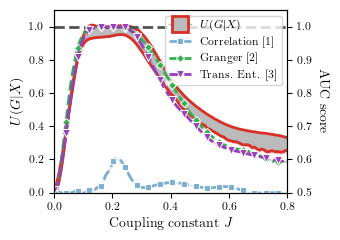

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.5))
ax = [None, ax]
display.Label.clear()

mi_color = display.med_colors["red"]
fcolor = "#bbbbbb"

hcolor = [display.light_colors["blue"], display.med_colors["green"], display.dark_colors["purple"]]
hmarker = ["s", "D", "v"]
hlinestyle = ["--"] * 3

# Reconstruction figure
mf.clip(min=0, max=1).lineplot(
    mf_x, 
    color=mi_color, 
    marker="None", 
    linestyle="-", 
    linewidth=2, 
    markersize=6, 
    interpolate="cubic",
    markevery=5,
    n_boot=1000,
    ax=ax[1],
)

ais.clip(min=0, max=1).lineplot(
    ais_x, 
    color=mi_color, 
    marker="None", 
    linestyle="-", 
    linewidth=2, 
    markersize=6, 
    interpolate="cubic",
    markevery=5,
    n_boot=1000,
    ax=ax[1],
)

augx, mf_augy = mf.interpolate(mf_x, kind="cubic")
_, ais_augy = ais.interpolate(ais_x, kind="cubic")
mf_augy = mf_augy.clip(0, 1)
ais_augy = ais_augy.clip(0, 1)
ax[1].fill_between(augx, mf_augy.loc, ais_augy.loc, color=fcolor)
handles = [
    display.get_label_line(
        r"$U(G|X)$", 
        marker="s",
        markersize=12,
        color=fcolor,
        markeredgecolor=mi_color,
        alpha=1,
        markeredgewidth=2,
    )
]

ax[1].axhline(1, color=display.med_colors["grey"], linewidth=2, linestyle="--")
ax[1].set_xlabel(r"Coupling constant $J$", fontsize=display.fontsizes["label"])
ax[1].set_ylabel(r"$U(G|X)$", fontsize=display.fontsizes["label"])
ax[1].set_xlim([mf_x.min(), mf_x.max()])
ax[1].set_ylim([0, 1.1])
ax[1].tick_params(axis="both", labelsize=display.fontsizes["tick"])

axx = ax[1].twinx()
# ax.set_zorder(axx.get_zorder() + 1)
# ax.patch.set_visible(False)
for i, m in enumerate(all_recon_methods):
    idx = recon_methods == m
    x = recon_x[idx]
    recon[idx].lineplot(
        x, 
        color=hcolor[i],
        linestyle=hlinestyle[i],
        marker=hmarker[i],
        linewidth=2,
        markersize=6 if i == 2 else 4,
        interpolate="cubic",
        markevery=5,
        n_boot=1000,
    )

    handles.append(display.get_label_line(recon_method_labels[m] + fr" [{i + 1}]", style=axx.get_lines()[-1]))
axx.set_ylim([0.5, 1.05])
axx.set_ylabel(r"AUC score", rotation=-90, ha="center", va="bottom", fontsize=display.fontsizes["label"])
axx.tick_params(axis="both", labelsize=display.fontsizes["tick"])

ax[1].legend(handles=handles, fontsize=display.fontsizes["legend"], loc="upper right")

fig.tight_layout()
fig.savefig("./recon-vs-heuristics.pdf")
# for p, fmt in product(paths_to_figures, ["svg", "pdf", "png"]):
#     fig.savefig(p / f"{fmt}/mi-vs-heuristics.{fmt}", bbox_inches='tight')
    
